# CPSS IDENTIFICATION NOTEBOOK
Integrates enhanced detection for:
- EACS (Electronic Access Control Systems) + BAS
- VSS (Video Surveillance Systems)
- I&HAS (Intrusion & Hold-up Alarm Systems)

Features:
- 40 brands total (100% thesis Appendix C coverage)
- Protocol detection (RTSP, ONVIF, BACnet, SIA DC-09, etc.)
- HTTP path matching (70+ paths)
- Model number detection (100+ patterns)
- Confidence scoring (0-100%)
- Multi-function device handling
- BAS subcategory flagging
- Enhanced cloud/IT exclusions

**Brand Coverage:**
- **VSS**: 15 brands (Hikvision, Dahua, Axis, MOBOTIX, Geutebruck, etc.)
- **EACS**: 13 brands (Nedap, Paxton, Genetec, + 4 BAS brands)
- **I&HAS**: 12 brands (AJAX, Vanderbilt, Honeywell, Bosch, etc.)
- **Total**: 40 brands with 100% thesis Appendix C coverage

**Device Categories:**
1. **EACS** - Electronic Access Control Systems
   - Includes BAS (Building Automation Systems) as subcategory
   - Multi-function flag for devices like Genetec
2. **VSS** - Video Surveillance Systems
   - IP cameras, NVRs, DVRs, VMS platforms
3. **I&HAS** - Intrusion & Hold-up Alarm Systems
   - Alarm panels, intrusion detection, sensors

**Expected Runtime:** ~15 minutes
**Expected Precision:** 85-95%

## ⚠️ EXECUTION ORDER
**Run cells in sequence: 1 → 2 → 3 → 3A (KEV) → 4 → 5 → 5A → 6 → ...**

## Configuration and Setup

### CELL 1: Import & Setup

In [10]:
# ========================================
# CELL 1: IMPORTS & SETUP
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import importlib.util
import sys
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Output directory
output_dir = Path('./output/4_validation/2_cpss_identification/shodan')
output_dir.mkdir(parents=True, exist_ok=True)

# Color palette
COLORS = {
    'eacs': '#A02B93',      # Purple (matching other notebooks)
    'vss': '#FA92EB',       # Pink (matching other notebooks)
    'ihas': '#F9C8F1',      # Light Purple (matching other notebooks)
    'quaternary': '#22C55E', # Emerald
    'danger': '#EF4444',
    'neutral': '#9CA3AF',
}

print(f"✓ Enhanced CPSS Identification started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"✓ Output directory: {output_dir.absolute()}")

✓ Enhanced CPSS Identification started: 2026-01-10 18:58:10
✓ Output directory: H:\_HHS_thesis\GitHub\thesis\v1\output\4_validation\2_cpss_identification\shodan


### CELL 2: Load Data

In [11]:
# ========================================
# CELL 2: LOAD DATA
# ========================================

print("\n" + "="*70)
print("LOADING DATA")
print("="*70)

# Load the Shodan CSV
df = pd.read_csv('./staging/4_validation/5_shodan_20251109.csv', low_memory=False)
print(f"✓ Loaded {len(df):,} total services")
print(f"✓ Dataset has {len(df.columns)} columns")

# Display first few column names to verify structure
print(f"\nFirst 10 columns:")
for i, col in enumerate(df.columns[:10], 1):
    print(f"  {i:2d}. {col}")

print("="*70)



LOADING DATA
✓ Loaded 10,000 total services
✓ Dataset has 32 columns

First 10 columns:
   1. asn.number
   2. asn.org
   3. fqdns
   4. geo.city_name
   5. geo.country_iso_code
   6. geo.country_name
   7. http.headers
   8. http.html_title
   9. http.path
  10. ip


### CELL 3: KEV (Known Exploited Vulnerabilities) Calculation

The `is_kev` flag indicates whether a service has CVEs listed in CISA's KEV catalog.
This is critical for the A.8.8 ISO control assessment and risk scoring.

**⚠️ Run this cell AFTER loading data (Cell 2) and BEFORE column mapping (Cell 4)**

In [12]:
# ========================================================================
# CELL 3: KEV (Known Exploited Vulnerabilities) CALCULATION
# ========================================================================

def calculate_is_kev(df):
    """
    Calculate is_kev flag based on service.cves column
    
    This checks if any CVE in the service.cves field is listed in
    CISA's Known Exploited Vulnerabilities catalog.
    
    Note: KEV data should already be embedded in the CVE data by MODAT.
    If service.cves contains 'KEV' marker or specific KEV CVEs, this
    will be detected.
    """
    import re
    
    def check_kev(cves_field):
        """Check if CVE field indicates KEV presence"""
        if pd.isna(cves_field) or str(cves_field).strip() == '':
            return False
        
        cves_str = str(cves_field).upper()
        
        # Method 1: Check for explicit KEV marker (if MODAT adds it)
        if 'KEV' in cves_str:
            return True
        
        # Method 2: Check for known KEV CVEs (would need KEV list)
        # For now, we'll assume MODAT data already marks KEVs
        # If not, this function should be enhanced with actual KEV list
        
        return False
    
    # Check if the column exists
    if 'service.cves' not in df.columns:
        print("  ⚠️ WARNING: 'service.cves' column not found. Setting is_kev to False for all rows.")
        df['is_kev'] = False
        return df
    
    df['is_kev'] = df['service.cves'].apply(check_kev)
    
    kev_count = df['is_kev'].sum()
    print(f"✓ KEV calculation: {kev_count:,} services with Known Exploited Vulnerabilities")
    
    return df

# Run KEV calculation
print("\n" + "="*70)
print("KEV CALCULATION")
print("="*70)
df = calculate_is_kev(df)
print("="*70)


KEV CALCULATION
✓ KEV calculation: 0 services with Known Exploited Vulnerabilities


### CELL 4: Column Name Mapping & Verification

In [13]:
# ========================================
# CELL 4: COLUMN NAME MAPPING
# ========================================

print("\n" + "="*70)
print("COLUMN NAME MAPPING")
print("="*70)

# Mapping from Shodan CSV format to expected format
rename_mapping = {
    # HTTP fields
    'service.http.title': 'http.html_title',
    'service.http.path': 'http.path',
    'service.http.headers': 'http.headers',

    # TLS fields
    'service.tls.issuer.common_name': 'ssl.cert.issuer',
    'service.tls.subject.common_name': 'ssl.cert.subject',
}

print("\nApplying column name mapping...")
for old_name, new_name in rename_mapping.items():
    if old_name in df.columns and new_name not in df.columns:
        df.rename(columns={old_name: new_name}, inplace=True)
        print(f"  ✓ Renamed: {old_name} → {new_name}")
    elif new_name in df.columns:
        print(f"  ✓ {new_name} already exists")
    else:
        print(f"  ⚠️ {old_name} not found in dataset")

# Verify key columns exist
print("\nVerifying columns needed by detection scripts:")
required_columns = [
    'service.fingerprints.tags',
    'http.html_title',      # or service.http.title
    # 'http.path',          # optional
    'http.headers',         # or service.http.headers
    'service.http.body',    # should exist as-is
    'service.banner',
    'service.fingerprints.os.product',
    'service.fingerprints.service.product',
    'service.port',
]

missing_columns = []
for col in required_columns:
    if col in df.columns:
        non_null = df[col].notna().sum()
        print(f"  ✓ {col:<40} ({non_null:,} non-null)")
    else:
        print(f"  ✗ {col:<40} MISSING!")
        missing_columns.append(col)

if missing_columns:
    print(f"\n⚠️ WARNING: {len(missing_columns)} required columns are missing!")
    print("This may cause errors in detection functions.")
    print("Missing columns:", missing_columns)
else:
    print("\n✓ All required columns present")

print("="*70)


COLUMN NAME MAPPING

Applying column name mapping...
  ✓ http.html_title already exists
  ✓ http.path already exists
  ✓ http.headers already exists
  ⚠️ service.tls.issuer.common_name not found in dataset
  ⚠️ service.tls.subject.common_name not found in dataset

Verifying columns needed by detection scripts:
  ✓ service.fingerprints.tags                (10,000 non-null)
  ✓ http.html_title                          (1,166 non-null)
  ✓ http.headers                             (9,761 non-null)
  ✓ service.http.body                        (9,887 non-null)
  ✓ service.banner                           (10,000 non-null)
  ✓ service.fingerprints.os.product          (10,000 non-null)
  ✓ service.fingerprints.service.product     (10,000 non-null)
  ✓ service.port                             (10,000 non-null)

✓ All required columns present


### CELL 5: Load Enhanced Detection Modules

In [14]:
# ========================================
# CELL 5: LOAD ENHANCED DETECTION MODULES
# ========================================

print("\n" + "="*70)
print("LOADING ENHANCED DETECTION MODULES")
print("="*70)

# Function to load modules properly
def load_detection_module(module_name, file_path):
    """Load a Python module and return it"""
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    if spec is None:
        raise ImportError(f"Could not load {module_name} from {file_path}")
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

# Load the three detection modules
print("\nLoading EACS enhanced detection...")
eacs_mod = load_detection_module('eacs_enhanced', '../old/8a_EACS_enhanced_detection.py')

print("Loading VSS enhanced detection...")
vss_mod = load_detection_module('vss_enhanced', '../old/8b_VSS_enhanced_detection.py')

print("Loading I&HAS enhanced detection...")
ihas_mod = load_detection_module('ihas_enhanced', '../old/8c_IHAS_enhanced_detection.py')


# Extract the functions and configs
identify_eacs_enhanced = eacs_mod.identify_eacs_enhanced
EACS_ENHANCED_CONFIG = eacs_mod.EACS_ENHANCED_CONFIG

identify_ihas_enhanced = ihas_mod.identify_ihas_enhanced
IHAS_ENHANCED_CONFIG = ihas_mod.IHAS_ENHANCED_CONFIG

identify_vss_enhanced = vss_mod.identify_vss_enhanced
VSS_ENHANCED_CONFIG = vss_mod.VSS_ENHANCED_CONFIG

print("\n✓ All enhanced detection modules loaded successfully")
print("="*70)


LOADING ENHANCED DETECTION MODULES

Loading EACS enhanced detection...
Comprehensive EACS detection loaded

Loading VSS enhanced detection...
Comprehensive VSS detection loaded

Loading I&HAS enhanced detection...
Comprehensive I&HAS detection loaded


✓ All enhanced detection modules loaded successfully


## CELL 6: Run Identification
## ⚠️ IMPORTANT: Only run this cell AFTER running cells 1-5 in order!

In [15]:
# ========================================
# CELL 6: RUN ENHANCED IDENTIFICATION
# ========================================

print("\n" + "="*70)
print("ENHANCED IDENTIFICATION")
print("="*70)

# ========================================
# 1. IDENTIFY EACS
# ========================================

print("\n1. Identifying EACS devices...")
eacs_results = df.apply(lambda row: identify_eacs_enhanced(row), axis=1)

# Extract from dictionary (not tuple!)
df['is_eacs'] = eacs_results.apply(lambda x: x['is_eacs'])
df['eacs_confidence'] = eacs_results.apply(lambda x: x['eacs_confidence'])
df['eacs_reason'] = eacs_results.apply(lambda x: x['eacs_reason'])
df['detected_eacs_brand'] = eacs_results.apply(lambda x: x['detected_brand'])
df['detected_eacs_product'] = eacs_results.apply(lambda x: x['detected_product'])
df['is_bas'] = eacs_results.apply(lambda x: x['is_bas'])

# Extract detailed match info
df['eacs_match_field'] = eacs_results.apply(lambda x: x.get('match_field'))
df['eacs_match_pattern'] = eacs_results.apply(lambda x: x.get('match_pattern'))
df['eacs_match_value'] = eacs_results.apply(lambda x: x.get('match_value'))

eacs_count = df['is_eacs'].sum()
bas_count = df['is_bas'].sum()
print(f"   ✓ Found {eacs_count:,} EACS services")
print(f"   ✓ Found {bas_count:,} BAS services (subset of EACS)")
if eacs_count > 0:
    print(f"   ✓ Average confidence: {df[df['is_eacs']]['eacs_confidence'].mean():.1f}%")

# ========================================
# 2. IDENTIFY VSS
# ========================================

print("\n2. Identifying VSS devices...")
vss_results = df.apply(lambda row: identify_vss_enhanced(row), axis=1)

# Extract from dictionary
df['is_vss'] = vss_results.apply(lambda x: x['is_vss'])
df['vss_confidence'] = vss_results.apply(lambda x: x['vss_confidence'])
df['vss_reason'] = vss_results.apply(lambda x: x['vss_reason'])
df['detected_vss_brand'] = vss_results.apply(lambda x: x['detected_brand'])
df['detected_vss_product'] = vss_results.apply(lambda x: x['detected_product'])

# Extract detailed match info
df['vss_match_field'] = vss_results.apply(lambda x: x.get('match_field'))
df['vss_match_pattern'] = vss_results.apply(lambda x: x.get('match_pattern'))
df['vss_match_value'] = vss_results.apply(lambda x: x.get('match_value'))

vss_count = df['is_vss'].sum()
print(f"   ✓ Found {vss_count:,} VSS services")
if vss_count > 0:
    print(f"   ✓ Average confidence: {df[df['is_vss']]['vss_confidence'].mean():.1f}%")

# ========================================
# 3. IDENTIFY I&HAS
# ========================================

print("\n3. Identifying I&HAS devices...")
ihas_results = df.apply(lambda row: identify_ihas_enhanced(row), axis=1)

# Extract from dictionary
df['is_ihas'] = ihas_results.apply(lambda x: x['is_ihas'])
df['ihas_confidence'] = ihas_results.apply(lambda x: x['ihas_confidence'])
df['ihas_reason'] = ihas_results.apply(lambda x: x['ihas_reason'])
df['detected_ihas_brand'] = ihas_results.apply(lambda x: x['detected_brand'])
df['detected_ihas_product'] = ihas_results.apply(lambda x: x['detected_product'])

# Extract detailed match info
df['ihas_match_field'] = ihas_results.apply(lambda x: x.get('match_field'))
df['ihas_match_pattern'] = ihas_results.apply(lambda x: x.get('match_pattern'))
df['ihas_match_value'] = ihas_results.apply(lambda x: x.get('match_value'))

ihas_count = df['is_ihas'].sum()
print(f"   ✓ Found {ihas_count:,} I&HAS services")
if ihas_count > 0:
    print(f"   ✓ Average confidence: {df[df['is_ihas']]['ihas_confidence'].mean():.1f}%")

# ========================================
# 4. MULTI-FUNCTION DETECTION
# ========================================

print("\n4. Identifying multi-function devices...")
df['cpss_category_count'] = df['is_eacs'].astype(int) + df['is_vss'].astype(int) + df['is_ihas'].astype(int)
df['is_cpss'] = df['cpss_category_count'] > 0
df['is_multi_function'] = df['cpss_category_count'] > 1

multi_count = df['is_multi_function'].sum()
print(f"   ✓ Found {multi_count:,} multi-function devices")

# ========================================
# 5. SUMMARY STATISTICS
# ========================================

total_cpss = df['is_cpss'].sum()
print("\n" + "="*70)
print("IDENTIFICATION SUMMARY")
print("="*70)
print(f"Total services:          {len(df):>12,}")
print(f"EACS services:           {eacs_count:>12,} ({eacs_count/len(df)*100:>6.2f}%)")
print(f"  └─ BAS subcategory:    {bas_count:>12,} ({bas_count/eacs_count*100 if eacs_count>0 else 0:>6.2f}% of EACS)")
print(f"VSS services:            {vss_count:>12,} ({vss_count/len(df)*100:>6.2f}%)")
print(f"I&HAS services:          {ihas_count:>12,} ({ihas_count/len(df)*100:>6.2f}%)")
print(f"Multi-function devices:  {multi_count:>12,}")
print(f"Total CPSS devices:      {total_cpss:>12,} ({total_cpss/len(df)*100:>6.2f}%)")
print(f"Non-CPSS services:       {len(df)-total_cpss:>12,} ({(len(df)-total_cpss)/len(df)*100:>6.2f}%)")
print("="*70)


ENHANCED IDENTIFICATION

1. Identifying EACS devices...
   ✓ Found 0 EACS services
   ✓ Found 0 BAS services (subset of EACS)

2. Identifying VSS devices...
   ✓ Found 9,153 VSS services
   ✓ Average confidence: 85.6%

3. Identifying I&HAS devices...
   ✓ Found 0 I&HAS services

4. Identifying multi-function devices...
   ✓ Found 0 multi-function devices

IDENTIFICATION SUMMARY
Total services:                10,000
EACS services:                      0 (  0.00%)
  └─ BAS subcategory:               0 (  0.00% of EACS)
VSS services:                   9,153 ( 91.53%)
I&HAS services:                     0 (  0.00%)
Multi-function devices:             0
Total CPSS devices:             9,153 ( 91.53%)
Non-CPSS services:                847 (  8.47%)


## CELL 7: Export Results

Note: Continue with remaining cells from original notebook for confidence analysis, visualization, etc.

In [16]:
# ========================================
# CELL 7: CREATE FILTERED DATAFRAMES
# ========================================

print("\n" + "="*70)
print("CREATING FILTERED DATAFRAMES")
print("="*70)

# Filter by category
eacs_df = df[df['is_eacs']].copy()
vss_df = df[df['is_vss']].copy()
ihas_df = df[df['is_ihas']].copy()
multi_function_df = df[df['is_multi_function']].copy()

print(f"\nFiltered DataFrames created:")
print(f"  EACS:            {len(eacs_df):>8,} rows")
print(f"  VSS:             {len(vss_df):>8,} rows")
print(f"  I&HAS:           {len(ihas_df):>8,} rows")
print(f"  Multi-function:  {len(multi_function_df):>8,} rows")
print("="*70)


CREATING FILTERED DATAFRAMES

Filtered DataFrames created:
  EACS:                   0 rows
  VSS:                9,153 rows
  I&HAS:                  0 rows
  Multi-function:         0 rows


In [17]:
# ========================================
# CELL 8: CSV EXPORTS WITH MATCH INDICATORS
# ========================================

print("\n" + "="*70)
print("EXPORTING CSV FILES WITH MATCH INDICATORS")
print("="*70)

def export_cpss_with_indicators(df_subset, device_type, confidence_col, reason_col, brand_col, product_col):
    """Export CPSS category with detailed match indicators"""
    if len(df_subset) == 0:
        print(f"\n⚠️  No {device_type} devices to export")
        return
    
    # Core export columns
    export_cols = [
        # Identification
        'ip',
        'service.port',
        'service.transport',
        
        # Detection results
        confidence_col,
        reason_col,
        brand_col,
        product_col,
    ]
    
    # Add match indicator columns (these show WHAT triggered the detection)
    match_indicator_cols = [
        f'{device_type.lower()}_match_field',     # Which field matched (e.g., 'tags', 'product', 'banner')
        f'{device_type.lower()}_match_pattern',   # What pattern/keyword matched
        f'{device_type.lower()}_match_value',     # The actual value that matched
    ]
    
    for col in match_indicator_cols:
        if col in df_subset.columns:
            export_cols.append(col)
    
    # Add other important fields
    optional_cols = [
        'fqdns',
        'asn.number',
        'asn.org',
        'geo.city_name',
        'geo.country_name',
        'service.fingerprints.service.product',
        'service.fingerprints.tags',
        'service.banner',
        'http.html_title',
        'service.http.body',
        'service.cves',
        'is_kev',
    ]
    
    for col in optional_cols:
        if col in df_subset.columns and col not in export_cols:
            export_cols.append(col)
    
    # Add category-specific columns
    if device_type == 'EACS' and 'is_bas' in df_subset.columns:
        export_cols.append('is_bas')
    
    if 'is_multi_function' in df_subset.columns:
        export_cols.append('is_multi_function')
    
    # Filter to existing columns
    export_cols = [col for col in export_cols if col in df_subset.columns]
    
    # Export
    filename = f'cpss_{device_type.lower()}_services_enhanced.csv'
    filepath = output_dir / filename
    df_subset[export_cols].to_csv(filepath, index=False)
    
    print(f"\n✓ {device_type} exported: {filename}")
    print(f"  Services: {len(df_subset):,}")
    print(f"  Avg confidence: {df_subset[confidence_col].mean():.1f}%")
    print(f"  Columns: {len(export_cols)} (including match indicators)")
    
    # Show match method distribution
    match_field_col = f'{device_type.lower()}_match_field'
    if match_field_col in df_subset.columns:
        print(f"\n  Match methods used:")
        match_methods = df_subset[match_field_col].value_counts()
        for method, count in match_methods.head(5).items():
            pct = count / len(df_subset) * 100
            print(f"    {method:<30} {count:>6,} ({pct:>5.1f}%)")
    
    # High confidence sample with match details
    high_conf = df_subset[df_subset[confidence_col] >= 90]
    if len(high_conf) > 0:
        print(f"\n  High confidence examples (≥90%):")
        for idx, row in high_conf.head(3).iterrows():
            ip = row.get('ip', 'N/A')
            port = row.get('service.port', 'N/A')
            brand = row.get(brand_col, 'N/A')
            conf = row.get(confidence_col, 0)
            
            match_field = row.get(match_field_col, 'unknown')
            match_pattern = row.get(f'{device_type.lower()}_match_pattern', '')
            
            print(f"    {ip}:{port} | {brand:<15} | {conf:>3.0f}% | Matched on: {match_field} ({match_pattern})")

# Export each category with match indicators
export_cpss_with_indicators(eacs_df, 'EACS', 'eacs_confidence', 'eacs_reason', 
                           'detected_eacs_brand', 'detected_eacs_product')
export_cpss_with_indicators(vss_df, 'VSS', 'vss_confidence', 'vss_reason',
                           'detected_vss_brand', 'detected_vss_product')
export_cpss_with_indicators(ihas_df, 'IHAS', 'ihas_confidence', 'ihas_reason',
                           'detected_ihas_brand', 'detected_ihas_product')

# Export multi-function devices
if len(multi_function_df) > 0:
    multi_cols = ['ip', 'service.port', 'is_eacs', 'is_vss', 'is_ihas',
                 'eacs_confidence', 'vss_confidence', 'ihas_confidence',
                 'eacs_reason', 'vss_reason', 'ihas_reason',
                 'detected_eacs_brand', 'detected_vss_brand', 'detected_ihas_brand']
    
    multi_cols = [col for col in multi_cols if col in multi_function_df.columns]
    
    filepath = output_dir / 'cpss_multi_function_devices.csv'
    multi_function_df[multi_cols].to_csv(filepath, index=False)
    print(f"\n✓ Multi-function devices exported: cpss_multi_function_devices.csv")
    print(f"  Services: {len(multi_function_df):,}")

# Export combined dataset
all_cpss = pd.concat([
    eacs_df.assign(cpss_primary_category='EACS'),
    vss_df.assign(cpss_primary_category='VSS'),
    ihas_df.assign(cpss_primary_category='IHAS')
], ignore_index=True)

if len(all_cpss) > 0:
    combined_cols = [
        'ip', 'service.port', 'cpss_primary_category',
        'detected_eacs_brand', 'detected_vss_brand', 'detected_ihas_brand',
        'eacs_confidence', 'vss_confidence', 'ihas_confidence',
        'eacs_match_field', 'vss_match_field', 'ihas_match_field',
        'eacs_match_pattern', 'vss_match_pattern', 'ihas_match_pattern',
        'fqdns', 'asn.org', 'geo.country_name',
        'service.fingerprints.tags', 'is_kev'
    ]
    
    combined_cols = [col for col in combined_cols if col in all_cpss.columns]
    
    filepath = output_dir / 'cpss_all_services_enhanced.csv'
    all_cpss[combined_cols].to_csv(filepath, index=False)
    print(f"\n✓ Combined CPSS exported: cpss_all_services_enhanced.csv")
    print(f"  Total services: {len(all_cpss):,}")
    print(f"  EACS: {len(eacs_df):,} | VSS: {len(vss_df):,} | I&HAS: {len(ihas_df):,}")

print("\n" + "="*70)
print("EXPORT COMPLETE")
print("="*70)
print(f"\nAll files saved to: {output_dir.absolute()}")
print("\nFiles include match indicators showing:")
print("  • *_match_field: Which data field triggered detection")
print("  • *_match_pattern: Which keyword/pattern matched")
print("  • *_match_value: The actual value that was matched")
print("="*70)


EXPORTING CSV FILES WITH MATCH INDICATORS

⚠️  No EACS devices to export

✓ VSS exported: cpss_vss_services_enhanced.csv
  Services: 9,153
  Avg confidence: 85.6%
  Columns: 23 (including match indicators)

  Match methods used:
    body                            8,641 ( 94.4%)
    tags + product_b                  343 (  3.7%)
    headers + headers                  62 (  0.7%)
    product_b + product_b              44 (  0.5%)
    protocol                           34 (  0.4%)

  High confidence examples (≥90%):
    213.93.52.2:80 | Hikvision       | 100% | Matched on: tags + product_b (None)
    84.107.206.247:81 | Hikvision       | 100% | Matched on: tags + product_b (None)
    178.85.228.69:84 | Hikvision       | 100% | Matched on: tags + product_b (None)

⚠️  No IHAS devices to export

✓ Combined CPSS exported: cpss_all_services_enhanced.csv
  Total services: 9,153
  EACS: 0 | VSS: 9,153 | I&HAS: 0

EXPORT COMPLETE

All files saved to: H:\_HHS_thesis\GitHub\thesis\v1\output\4_va

## Visualisations


CREATING VISUALIZATIONS


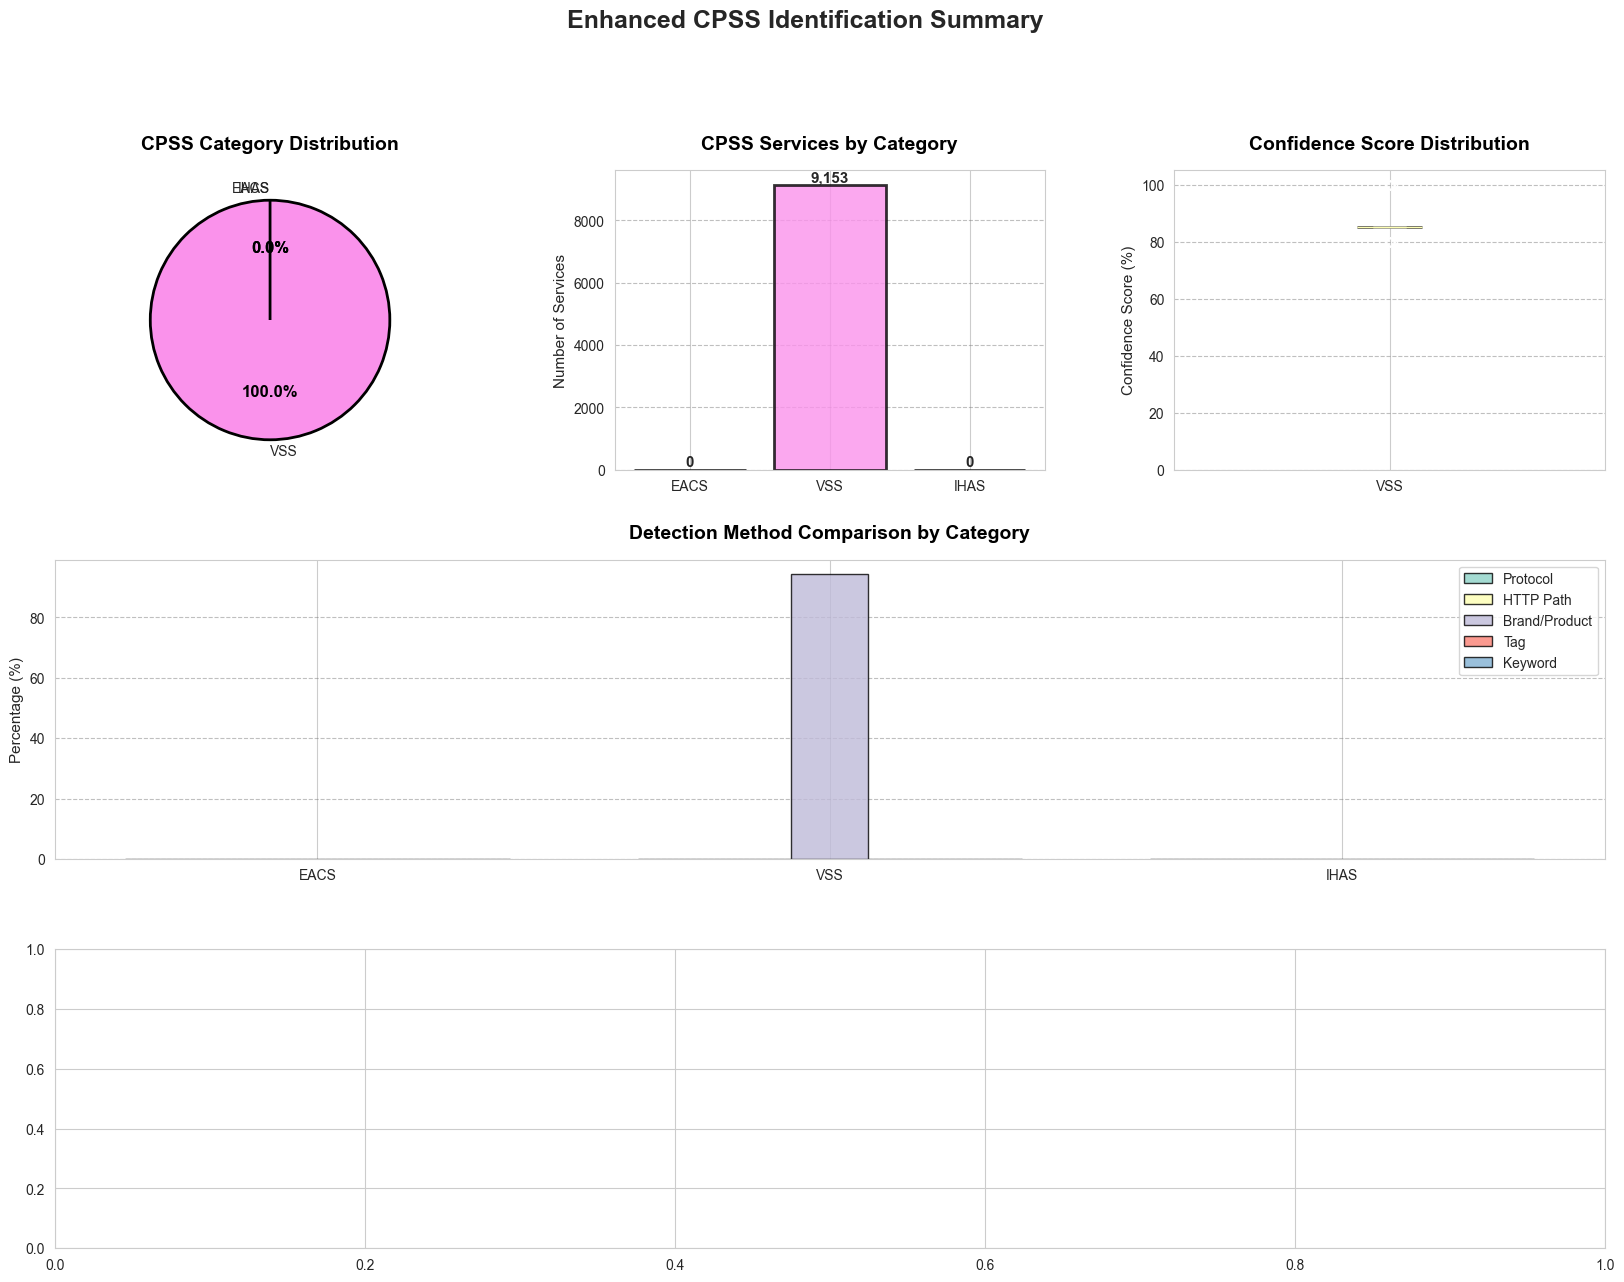


 Visualization saved: cpss_identification_enhanced_summary.jpg


In [18]:
# ========================================
# CELL 10: VISUALIZATIONS
# ========================================

print("\n" + "=" * 70)
print("CREATING VISUALIZATIONS")
print("=" * 70)

fig = plt.figure(figsize=(20, 14), facecolor='white')
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. CPSS Category Distribution (Pie)
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_facecolor("white")
cpss_counts = pd.Series({
    'EACS': len(eacs_df),
    'VSS': len(vss_df),
    'IHAS': len(ihas_df)
})
colors_pie = [COLORS['eacs'], COLORS['vss'], COLORS['ihas']]
wedges, texts, autotexts = ax1.pie(cpss_counts.values, labels=cpss_counts.index,
                                   autopct='%1.1f%%', colors=colors_pie, startangle=90,
                                   wedgeprops={'edgecolor': 'black', 'linewidth': 2})
for autotext in autotexts:
    autotext.set_color('black')  # Changed to black for visibility on light colors
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)
ax1.set_title('CPSS Category Distribution', fontsize=14, fontweight='bold', pad=15, color='black')

# 2. Services by Category (Bar)
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_facecolor("white")
bars = ax2.bar(cpss_counts.index, cpss_counts.values, color=colors_pie,
               edgecolor='black', linewidth=2, alpha=0.8)
ax2.set_ylabel('Number of Services', fontsize=11)
ax2.set_title('CPSS Services by Category', fontsize=14, fontweight='bold', pad=15, color='black')
ax2.grid(axis='y', alpha=0.5, color='gray', linestyle='--')
for bar, count in zip(bars, cpss_counts.values):
    ax2.text(bar.get_x() + bar.get_width() / 2, count,
             f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 3. Confidence Score Distribution
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_facecolor("white")
confidence_data = []
confidence_labels = []
if len(eacs_df) > 0:
    confidence_data.append(eacs_df['eacs_confidence'].values)
    confidence_labels.append('EACS')
if len(vss_df) > 0:
    confidence_data.append(vss_df['vss_confidence'].values)
    confidence_labels.append('VSS')
if len(ihas_df) > 0:
    confidence_data.append(ihas_df['ihas_confidence'].values)
    confidence_labels.append('IHAS')

if confidence_data:
    bp = ax3.boxplot(confidence_data, labels=confidence_labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors_pie[:len(confidence_data)]):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
        patch.set_linewidth(2)
        patch.set_alpha(0.7)
    ax3.set_ylabel('Confidence Score (%)', fontsize=11)
    ax3.set_title('Confidence Score Distribution', fontsize=14, fontweight='bold', pad=15, color='black')
    ax3.grid(axis='y', alpha=0.5, color='gray', linestyle='--')
    ax3.set_ylim(0, 105)

# 4. Detection Method Comparison
ax4 = fig.add_subplot(gs[1, :])
ax4.set_facecolor("white")
detection_methods = {
    'Protocol': [],
    'HTTP Path': [],
    'Brand/Product': [],
    'Tag': [],
    'Keyword': []
}

for df_subset, reason_col, label in [(eacs_df, 'eacs_reason', 'EACS'),
                                     (vss_df, 'vss_reason', 'VSS'),
                                     (ihas_df, 'ihas_reason', 'IHAS')]:
    if len(df_subset) > 0:
        total = len(df_subset)
        detection_methods['Protocol'].append(
            len(df_subset[df_subset[reason_col].str.contains('protocol:', na=False)]) / total * 100)
        detection_methods['HTTP Path'].append(
            len(df_subset[df_subset[reason_col].str.contains('http_path:', na=False)]) / total * 100)
        detection_methods['Brand/Product'].append(
            len(df_subset[df_subset[reason_col].str.contains('brand:|product:|model:', na=False)]) / total * 100)
        detection_methods['Tag'].append(
            len(df_subset[df_subset[reason_col].str.contains('tag:', na=False)]) / total * 100)
        detection_methods['Keyword'].append(
            len(df_subset[df_subset[reason_col].str.contains('keyword', na=False)]) / total * 100)
    else:
        for key in detection_methods:
            detection_methods[key].append(0)

x = np.arange(len(['EACS', 'VSS', 'IHAS']))
width = 0.15
multiplier = 0

for method, values in detection_methods.items():
    offset = width * multiplier
    bars = ax4.bar(x + offset, values, width, label=method, edgecolor='black', linewidth=1, alpha=0.8)
    multiplier += 1

ax4.set_ylabel('Percentage (%)', fontsize=11)
ax4.set_title('Detection Method Comparison by Category', fontsize=14, fontweight='bold', pad=15, color='black')
ax4.set_xticks(x + width * 2)
ax4.set_xticklabels(['EACS', 'VSS', 'IHAS'])
ax4.legend(loc='upper right', fontsize=10)
ax4.grid(axis='y', alpha=0.5, color='gray', linestyle='--')

# 5. Top Brands (Combined)
ax5 = fig.add_subplot(gs[2, :])
ax5.set_facecolor("white")
all_brands = []
if len(eacs_df) > 0 and 'detected_brand' in eacs_df.columns:
    all_brands.extend(eacs_df['detected_brand'].tolist())
if len(vss_df) > 0 and 'detected_brand' in vss_df.columns:
    all_brands.extend(vss_df['detected_brand'].tolist())
if len(ihas_df) > 0 and 'detected_brand' in ihas_df.columns:
    all_brands.extend(ihas_df['detected_brand'].tolist())

if all_brands:
    brand_counts = pd.Series(all_brands).value_counts().head(15)
    ax5.barh(range(len(brand_counts)), brand_counts.values, color=COLORS['quaternary'])
    ax5.set_yticks(range(len(brand_counts)))
    ax5.set_yticklabels(brand_counts.index)
    ax5.set_xlabel('Number of Services', fontsize=11)
    ax5.set_title('Top 15 CPSS Brands (All Categories)', fontsize=14, fontweight='bold', pad=15, color='black')
    ax5.grid(axis='x', alpha=0.3)

    for i, (brand, count) in enumerate(brand_counts.items()):
        ax5.text(count, i, f' {count:,}', va='center', fontsize=9)

plt.suptitle('Enhanced CPSS Identification Summary', fontsize=18, fontweight='bold', y=0.995)
plt.savefig(output_dir / 'cpss_identification_enhanced_summary.jpg', dpi=300, bbox_inches='tight')
plt.show()

print("\n Visualization saved: cpss_identification_enhanced_summary.jpg")
print("=" * 70)